<a href="https://colab.research.google.com/github/AnaChavezHdz/Art-Driven-by-Visual-Representations-of-Chemical-Space/blob/main/02_PCA_WINE_TASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Install rdkit
      !pip -q install rdkit
      pbar.update(100)
import pandas as pd
import numpy as np
from sys import argv

  0%|          | 0/100 [00:00<?, ?it/s]

## 1.Load datasets

In [2]:
# Read data set
url_wine_tasting = "https://raw.githubusercontent.com/AnaChavezHdz/Art-Driven-by-Visual-Representations-of-Chemical-Space/main/Datasets/02_wine_notes_16JUNE2023.csv"
DATA = pd.read_csv(url_wine_tasting)
DATA.head(2)

,COMPOUND_ID,NAME_FOOD_DB,NEW_SMILES,FLAVOR_ID,NAME_FLAVOR,FLAVOR_GROUP
0,373,Prenyl acetate,CC(=O)OCC=C(C)C,71.0,banana,fruity
1,411,Geranyl 3-methylbutanoate,CC(C)=CCCC(C)=CCOC(=O)CC(C)C,69.0,apple,fruity


In [3]:
DATA.columns

Index(['COMPOUND_ID', 'NAME_FOOD_DB', 'NEW_SMILES', 'FLAVOR_ID', 'NAME_FLAVOR',
       'FLAVOR_GROUP'],
      dtype='object')

In [4]:
set(list(DATA["FLAVOR_GROUP"]))

{'floral', 'fruity'}

In [5]:
# See columns
print(DATA.columns)

Index(['COMPOUND_ID', 'NAME_FOOD_DB', 'NEW_SMILES', 'FLAVOR_ID', 'NAME_FLAVOR',
       'FLAVOR_GROUP'],
      dtype='object')


In [6]:
# Select columns
DATA = DATA[["FLAVOR_ID", "NEW_SMILES", "FLAVOR_GROUP"]]
# Change column name
DATA.columns = ["ID", "SMILES", "Label"]
DATA.head(2)

,ID,SMILES,Label
0,71.0,CC(=O)OCC=C(C)C,fruity
1,69.0,CC(C)=CCCC(C)=CCOC(=O)CC(C)C,fruity


## 2.Calculate molecular descriptors

In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

DATA["HBA"] = [Descriptors.NumHAcceptors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["HBD"] = [Descriptors.NumHDonors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["RB"] = [Descriptors.NumRotatableBonds(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["LogP"] = [Descriptors.MolLogP(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["TPSA"] = [Descriptors.TPSA(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["MW"] = [Descriptors.MolWt(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]

In [8]:
DATA.head(2)

,ID,SMILES,Label,HBA,HBD,RB,LogP,TPSA,MW
0,71.0,CC(=O)OCC=C(C)C,fruity,2,0,2,1.5157,26.3,128.171
1,69.0,CC(C)=CCCC(C)=CCOC(=O)CC(C)C,fruity,2,0,7,4.2684,26.3,238.371


In [9]:
DATA = DATA[["Label", "HBA", "HBD", "RB", "LogP", "TPSA", "MW"]]
DATA.head(2)

,Label,HBA,HBD,RB,LogP,TPSA,MW
0,fruity,2,0,2,1.5157,26.3,128.171
1,fruity,2,0,7,4.2684,26.3,238.371


### 3. Split data

In [10]:
X = DATA.iloc[:,1:7].values # Molecular descriptors
y = DATA.iloc[:,0].values # Labels
pd.DataFrame(X).head(2)

,0,1,2,3,4,5
0,2.0,0.0,2.0,1.5157,26.3,128.171
1,2.0,0.0,7.0,4.2684,26.3,238.371


## 4. Standardization and Normalization

In [11]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)
pd.DataFrame(X_std).head(2)

(1024, 6)


,0,1,2,3,4,5
0,0.075403,-0.445762,-0.913947,-0.983296,-0.044699,-1.053887
1,0.075403,-0.445762,0.906835,1.494522,-0.044699,1.390522


## 5. Covarianze matrix

In [12]:
# 2. Find the Covarianze matrix
cov_mat = np.cov(X_std.T)
#Eigenvectors and Eigenvalues
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(eig_vals)
# Sort Eigenvectors and Eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
# Sort Eigenvalues by descending order
print('Autovalores en orden descendiente:')
for i in eig_pairs:
    print(i[0])

[2.38852823 2.07567233 0.96016386 0.03143724 0.10864435 0.4414191 ]
Autovalores en orden descendiente:
2.3885282263940475
2.0756723285077077
0.9601638641597655
0.4414190961473035
0.1086443464823982
0.03143724094807347


In [13]:
#Variance explained
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
print(var_exp)
#Cumulative variance
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[39.76992798829933, 34.560755079156664, 15.987103402269536, 7.349800380187037, 1.8089708081297748, 0.5234423419576687]
[ 39.76992799  74.33068307  90.31778647  97.66758685  99.47655766
 100.        ]


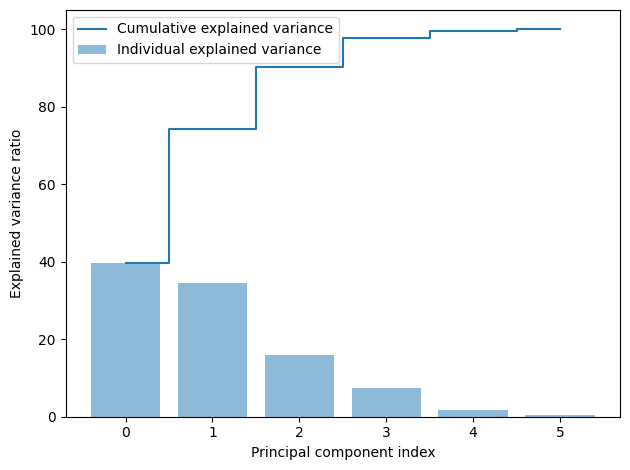

In [14]:
# Create the visualization plot
import matplotlib.pyplot as plt
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_var_exp)), cum_var_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
# Covariance matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1),
                      eig_pairs[1][1].reshape(6,1)))
print("Matriz W:\n", matrix_w)
print(matrix_w.shape)

Matriz W:
 [[ 0.21458844  0.58951803]
 [-0.0277206   0.29357962]
 [ 0.53166003 -0.10311338]
 [ 0.51335416 -0.38252141]
 [ 0.19697108  0.63968584]
 [ 0.60678735  0.01124786]]
(6, 2)


## 6. Generate PC1 and PC2

In [16]:
# PC_1 and PC_2
Y = X_std.dot(matrix_w)
print(Y.shape)
Y2 = pd.DataFrame(Y, columns=["PC_1", "PC_2"])
Y2["Label"] = DATA["Label"]
Y2.head(5)

(1024, 2)


,PC_1,PC_2,Label
0,-1.610440,0.343509,fruity
1,2.112831,-0.764561,fruity
2,2.935691,-1.020098,fruity
3,0.271163,-0.199151,fruity
4,1.354569,-0.082790,fruity


## 7. Plot PCA

Mounted at /content/drive


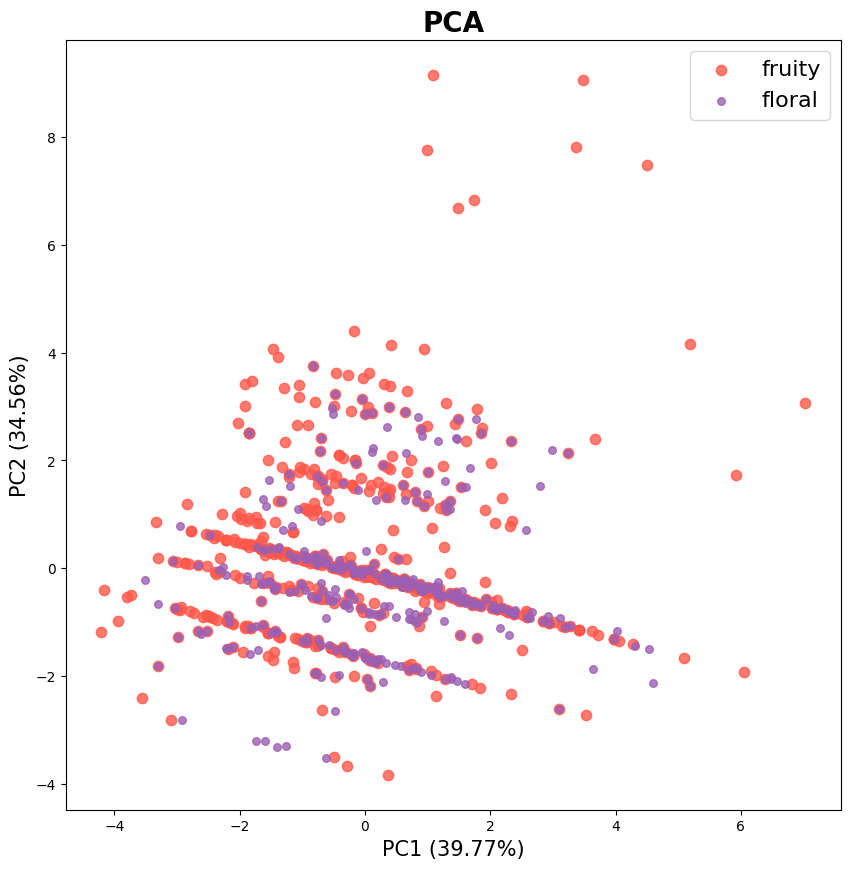

In [17]:
# Plot PCA

# Colors
from matplotlib.colors import ListedColormap
# Define labels
labels = 'fruity', 'floral'
# Define colores
colors_data = ['#ff584b','#9c5fb3', '#7b4b00']
# Define format
marker='o' "o" 'o'
# Shape size
s=55, 30


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

# Show PCA
for label, color, marker, s in zip((labels),
                        (colors_data), (marker), (s)):
  plt.scatter(Y[y==label, 0],
              Y[y==label, 1],
              alpha=0.8,
              label=label,
              color=color,
              marker=marker,
              s=s)
# Add the percentage of variance
plt.xlabel("PC1 (%2.2f" % var_exp[0] +str("%)"), fontsize=15)
plt.ylabel("PC2 (%2.2f" %var_exp[1] +str("%)"), fontsize=15)

# Axes
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# Legends
plt.legend(loc='best', fontsize=16)
plt.title("PCA", fontsize=20, fontweight="bold")

# Save figure
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
plt.savefig("PCA_wine_tasting.jpg", dpi=500)

links:
1. https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/
2. https://www.cienciadedatos.net/documentos/35_principal_component_analysis